In [1]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial
import scipy.constants as const

In [2]:
#Data from vizier without treatment
raw_data = pd.read_csv(r"C:\Users\clauw\Documents\Programming\VIS_data_vizier.tsv", delimiter='\t',names=["Wave (cm)", "nFlux", "rFlux"])

In [3]:
#Convert the wavelength in A cause its in cm^-1 
raw_data['Wave A'] = (10**(8))/raw_data['Wave (cm)']

#Invert the values for the index in python
raw_data = raw_data.sort_values('Wave A', ascending=True, na_position='first').reset_index(drop=True)

raw_data

,Wave (cm),nFlux,rFlux,Wave A
0,24700.085804,0.913045,0.002181,4048.568932
1,24700.082038,0.911843,0.002247,4048.569549
2,24700.078271,0.883065,0.002311,4048.570167
3,24700.074505,0.862602,0.002342,4048.570784
4,24700.070738,0.867600,0.002327,4048.571401
...,...,...,...,...
4057457,9387.232391,1.000976,0.013178,10652.767060
4057458,9387.228625,1.000718,0.013185,10652.771334
4057459,9387.224858,1.001793,0.013186,10652.775608
4057460,9387.221092,1.003057,0.013182,10652.779883


In [4]:
#Lines from the file of Clean lines
raw_lambda = pd.read_excel(r"C:\Users\clauw\Documents\Programming\Final-Project\Visible range\valores vacio Nave.xlsx", skiprows=10, usecols=[0], names=['Nave list'])
raw_lambda

,Nave list
0,4060.8601
1,4068.4198
2,4080.9899
3,4086.1573
4,4088.2476
...,...
614,10425.8870
615,10426.6020
616,10535.1220
617,10580.0390


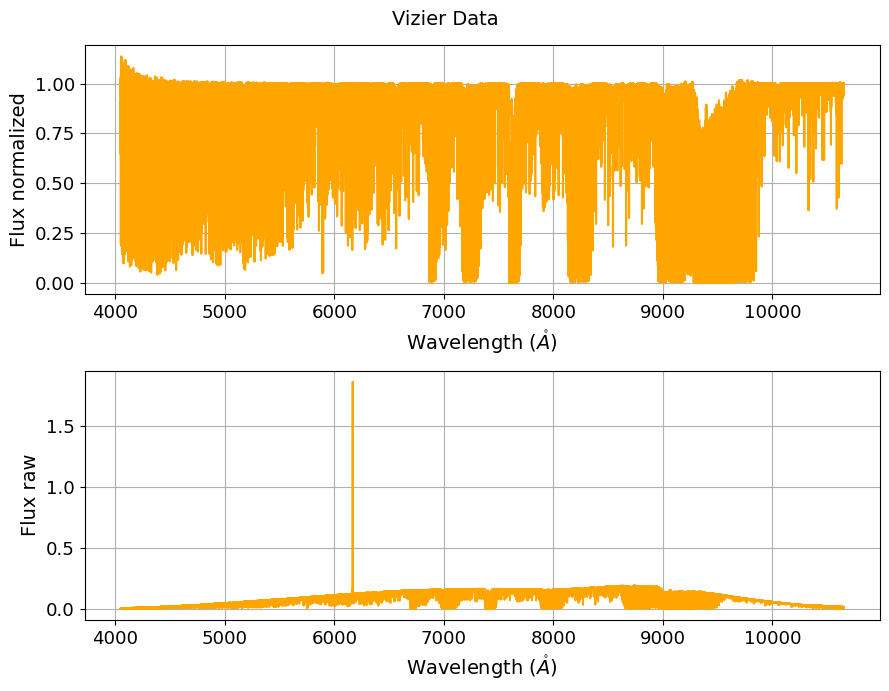

In [5]:
#Plot of raw data
fig1, axis1 = plt.subplots(2,1, figsize = (9, 7),)
ax1 = axis1[0]
ax2 = axis1[1]

fig1.suptitle(r'Vizier Data',fontsize=14)

ax1.plot(raw_data['Wave A'],raw_data['nFlux'],color='orange')
ax1.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=14)
ax1.set_ylabel('Flux normalized',fontsize=14)
ax1.grid()
ax1.tick_params(axis='both',labelsize=13)

ax2.plot(raw_data['Wave A'],raw_data['rFlux'],color='orange')
ax2.set_xlabel(r'Wavelength $(\mathring{A})$',fontsize=14)
ax2.set_ylabel('Flux raw',fontsize=14)
ax2.grid()
ax2.tick_params(axis='both',labelsize=13)

fig1.tight_layout()

### Wavelength classification

In [6]:
#Between work like < or > but not the equal, reset the index for the other functions
data_4000_5000 = raw_data[raw_data['Wave A'].between(4000, 5000, inclusive='neither')].reset_index(drop=True)
data_5000_6000 = raw_data[raw_data['Wave A'].between(5000, 6000, inclusive='neither')].reset_index(drop=True)
data_6000_7000 = raw_data[raw_data['Wave A'].between(6000, 7000, inclusive='neither')].reset_index(drop=True)
data_7000_8000 = raw_data[raw_data['Wave A'].between(7000, 8000, inclusive='neither')].reset_index(drop=True)
data_8000_9000 = raw_data[raw_data['Wave A'].between(8000, 9000, inclusive='neither')].reset_index(drop=True)
data_9000_10000 = raw_data[raw_data['Wave A'].between(9000, 10000, inclusive='neither')].reset_index(drop=True)
data_10000_11000 = raw_data[raw_data['Wave A'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)


data_4000_5000

,Wave (cm),nFlux,rFlux,Wave A
0,24700.085804,0.913045,0.002181,4048.568932
1,24700.082038,0.911843,0.002247,4048.569549
2,24700.078271,0.883065,0.002311,4048.570167
3,24700.074505,0.862602,0.002342,4048.570784
4,24700.070738,0.867600,0.002327,4048.571401
...,...,...,...,...
1247850,20000.015768,0.992487,0.043338,4999.996058
1247851,20000.012002,0.993481,0.043338,4999.997000
1247852,20000.008235,0.994571,0.043319,4999.997941
1247853,20000.004469,0.994641,0.043292,4999.998883


In [7]:
#Now from lambda
lambda_4000_5000 = raw_lambda[raw_lambda['Nave list'].between(4000, 5000, inclusive='neither')].reset_index(drop=True)
lambda_5000_6000 = raw_lambda[raw_lambda['Nave list'].between(5000, 6000, inclusive='neither')].reset_index(drop=True)
lambda_6000_7000 = raw_lambda[raw_lambda['Nave list'].between(6000, 7000, inclusive='neither')].reset_index(drop=True)
lambda_7000_8000 = raw_lambda[raw_lambda['Nave list'].between(7000, 8000, inclusive='neither')].reset_index(drop=True)
lambda_8000_9000 = raw_lambda[raw_lambda['Nave list'].between(8000, 9000, inclusive='neither')].reset_index(drop=True)
lambda_9000_10000 = raw_lambda[raw_lambda['Nave list'].between(9000, 10000, inclusive='neither')].reset_index(drop=True)
lambda_10000_11000 = raw_lambda[raw_lambda['Nave list'].between(10000, 11000, inclusive='neither')].reset_index(drop=True)


lambda_4000_5000

,Nave list
0,4060.8601
1,4068.4198
2,4080.9899
3,4086.1573
4,4088.2476
...,...
141,4986.9382
142,4987.6138
143,4990.3419
144,4992.6608


### Find the minimums and the closer line of the Fe I line


In [ ]:
#Find the minimum or the lambda in the spectrum
def find_minimums(wave,flux,lamda):
    #The function find_peaks just got the index of the points
    #The minus if for the minimums, without it are the maximums
    minimums,_ = find_peaks(-flux) 
    mindf = pd.DataFrame([]) #Make a dataframe
    mindf['min_wave'] = wave[minimums]
    mindf['min_flux'] = flux[minimums]

    #Take the closer line with the absolute value of the difference between the minimums and the line
    #This step dont include the closer points that are not minimums
    closer = []
    for each in lamda:
        mindf['abs'] = np.abs(mindf['min_wave']-each)
        closer.append(mindf.loc[mindf['abs'] == min(mindf['abs'])]) #Take all the row

    #Dataframe with the marks for the closer lines of Fe I
    closer_data = pd.concat(closer,axis=0).reset_index(drop=True)
    closer_data['Fe line'] = lamda

    return closer_data.drop(['abs'],axis=1)

closer_lines_4000_5000= find_minimums(data_4000_5000['Wave A'],data_4000_5000['nFlux'],lambda_4000_5000['Nave list'])
closer_lines_5000_6000 = find_minimums(data_5000_6000['Wave A'],data_5000_6000['nFlux'],lambda_5000_6000['Nave list'])
closer_lines_6000_7000 = find_minimums(data_6000_7000['Wave A'],data_6000_7000['nFlux'],lambda_6000_7000['Nave list'])
closer_lines_7000_8000 = find_minimums(data_7000_8000['Wave A'],data_7000_8000['nFlux'],lambda_7000_8000['Nave list'])
closer_lines_8000_9000 = find_minimums(data_8000_9000['Wave A'],data_8000_9000['nFlux'],lambda_8000_9000['Nave list'])
closer_lines_9000_10000 = find_minimums(data_9000_10000['Wave A'],data_9000_10000['nFlux'],lambda_9000_10000['Nave list'])
closer_lines_10000_11000 = find_minimums(data_10000_11000['Wave A'],data_10000_11000['nFlux'],lambda_10000_11000['Nave list'])


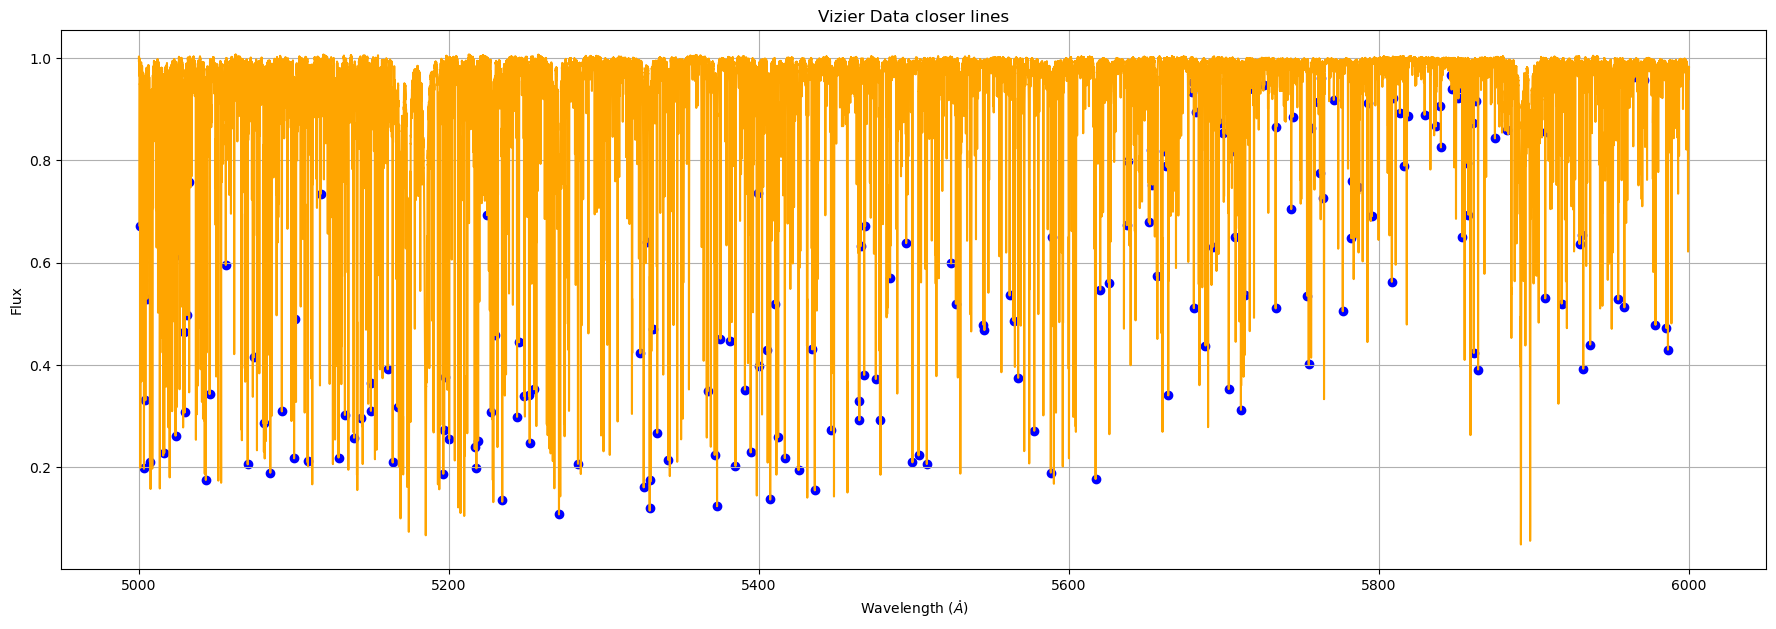

In [9]:
#Plot the identified lines
fig2, ax = plt.subplots(1,1,figsize=(22,7))
ax.plot(data_5000_6000['Wave A'],data_5000_6000['nFlux'], color='orange')
ax.scatter(closer_lines_5000_6000['min_wave'],closer_lines_5000_6000['min_flux'], color='blue')
ax.set_title('Vizier Data closer lines')
ax.set_xlabel(r'Wavelength $(\mathring{A})$')
ax.set_ylabel('Flux')
ax.grid()

In [10]:
#Localize the line and save the width for lines
def width_minimums(closer_lines,data,width):
    local_points =[]
    for each in closer_lines['min_wave']:
        #This append all the part of the dataframe in that range
        local_points.append(data[data['Wave A'].between(each-width, each+width, inclusive='neither')])

    return local_points

local_points_4000_5000 = width_minimums(closer_lines_4000_5000,data_4000_5000,0.05)
local_points_5000_6000 = width_minimums(closer_lines_5000_6000,data_5000_6000,0.05)
local_points_6000_7000 = width_minimums(closer_lines_6000_7000,data_6000_7000,0.05)
local_points_7000_8000 = width_minimums(closer_lines_7000_8000,data_7000_8000,0.05)
local_points_8000_9000 = width_minimums(closer_lines_8000_9000,data_8000_9000,0.05)
local_points_9000_10000 = width_minimums(closer_lines_9000_10000,data_9000_10000,0.05)
local_points_10000_11000 = width_minimums(closer_lines_10000_11000,data_10000_11000,0.05)


### Derivates and fit

In [46]:
def Fit_derivates(local_points,lamda_list):
    values = []
    fit = []

    for i in range(0,len(local_points)):

        data_wave, data_flux = local_points[i]['Wave A'], local_points[i]['nFlux'] #The index i correspond at one line in the lambda_list of Fe I lines 

        #Standarization, with the mean and std just for the big data (wavenumber)
        wave_mean, wave_std = np.mean(data_wave), np.std(data_wave) 
        wave_scaled = (data_wave - wave_mean)/wave_std if wave_std != 0 else data_wave #Take the conditional for the division in zero

        #Polynomial Fit is better for numerical aproximation than polyfit
        pol = Polynomial.fit(wave_scaled, data_flux, 4)

        #Scaled coeficients of fit
        param = pol.convert().coef

        #Calculate the derivates without evaluate the point, polyder takes the derivate of the polinomium
        d_param = poly.polyder(param) #First
        d2_param = poly.polyder(d_param) #Second
        d3_param = poly.polyder(d2_param) #Third

        #The fit values
        flux_fit = poly.polyval(wave_scaled,param)

        #Find the minimum with the regression and derivates
        roots = poly.polyroots(d_param).real #Roots or critical points
        valid_roots = np.array([x for x in roots if poly.polyval(x,d2_param)>0] )#Check with the second derivate, just positive values for minimums
        
        if valid_roots.size >0: 

            value_roots = pol(valid_roots) #Evaluate in the polinomium for the global minimum
            minimal_root = valid_roots[np.where(value_roots == min(value_roots))][0] , min(value_roots) #Take the values for the wavelength and the flux of the minimum

            #For the wavelength observed convert the minimal root in the real with the scale of the mean, we dont scale the flux data
            lamda_obs = [round(minimal_root[0]*wave_std + wave_mean,4), minimal_root[1]]

            #Expresion for the third derivate (C-curved profile bisector)
            def Third_Derivate(second, third):
                return -((third)/(3*(second**2)))

            #Evaluate the second and third derivate in the wavelength observed
            d2 = poly.polyval(minimal_root[0],d2_param) / (wave_std ** 2) #Re-scalated the coefficients
            d3 = Third_Derivate(d2, poly.polyval(minimal_root[0],d3_param) / (wave_std ** 3) ) 

            #Calculate the velocity and convective blueshift
            blueshift = ((lamda_obs[0]/lamda_list[i]) - 1)* const.c
            velocity = round((blueshift) - 633) #Formula for relativistic aproximation

            #In order: Natural wavelength, observed wavelength, flux, velocity, second derivate, third derivate, convective blueshift
            values.append(pd.DataFrame([[lamda_list[i],lamda_obs[0],lamda_obs[1],velocity,d2,d3,blueshift]])) 

            #Just in case of the visualizer take the fit values
            fit.append(flux_fit)

    Values =  pd.concat(values,axis=0).reset_index(drop=True)

    Values.columns = ["Emitted wavelength", "Observed wavelength", "Flux","Velocity","2nd Derivate","3rd Derivate","Blueshift"]

    return Values

Values_4000_5000 = Fit_derivates(local_points_4000_5000,lambda_4000_5000['Nave list'])
Values_5000_6000 = Fit_derivates(local_points_5000_6000,lambda_5000_6000['Nave list'])
Values_6000_7000 = Fit_derivates(local_points_6000_7000,lambda_6000_7000['Nave list'])
Values_7000_8000 = Fit_derivates(local_points_7000_8000,lambda_7000_8000['Nave list'])
Values_8000_9000 = Fit_derivates(local_points_8000_9000,lambda_8000_9000['Nave list'])
Values_9000_10000 = Fit_derivates(local_points_9000_10000,lambda_9000_10000['Nave list'])
Values_10000_11000 = Fit_derivates(local_points_10000_11000,lambda_10000_11000['Nave list'])

Values_4000_5000

,Emitted wavelength,Observed wavelength,Flux,Velocity,2nd Derivate,3rd Derivate,Blueshift
0,4060.8601,4060.8637,0.319656,-367,516.240027,0.002124,265.769522
1,4068.4198,4068.4255,0.209893,-213,305.398066,-0.005535,420.019834
2,4080.9899,4080.9941,0.214181,-324,412.428492,-0.004021,308.535026
3,4086.1573,4086.1634,0.220922,-185,317.419952,-0.005171,447.543709
4,4088.2476,4088.2510,0.288719,-384,466.796632,0.000710,249.323049
...,...,...,...,...,...,...,...
141,4986.9382,4986.9455,0.229707,-194,256.686130,-0.006365,438.843406
142,4987.6138,4987.6170,0.525382,-441,307.854384,0.000228,192.343655
143,4990.3419,4990.3473,0.307966,-309,318.605629,-0.002418,324.402477
144,4992.6608,4992.6663,0.307437,-303,299.507628,-0.002706,330.256467


In [12]:
Values = pd.concat([Values_4000_5000, Values_5000_6000, Values_6000_7000, Values_7000_8000,
                     Values_8000_9000, Values_9000_10000, Values_10000_11000],axis=0).reset_index(drop=True)


In [14]:
#Separate for color range, making a listfor the plot

values_colors = [ Values[Values["Observed wavelength"].between(3800, 4270, inclusive='neither')],
                 Values[Values["Observed wavelength"].between(4270, 4760, inclusive='neither')],
                 Values[Values["Observed wavelength"].between(4760, 4970, inclusive='neither')],
                 Values[Values["Observed wavelength"].between(4970, 5700, inclusive='neither')],
                 Values[Values["Observed wavelength"].between(5700, 5810, inclusive='neither')],
                 Values[Values["Observed wavelength"].between(5810, 6180, inclusive='neither')],
                 Values[Values["Observed wavelength"].between(6180, 7800, inclusive='neither')],
                 Values[Values["Observed wavelength"].between(7800, 11000, inclusive='neither')]
]

In [ ]:
##Convert to excel file
# Values.to_excel('valores_VIS.xlsx', index=False)

## Graphics 

As we have an absorption spectrum, the line depth is measurement one minus the flux value.

In [31]:
#Colors for the plot
colors = ['violet','blue','cyan','green','yellow','orange','red','brown']

### Velocity vs Normalized Flux

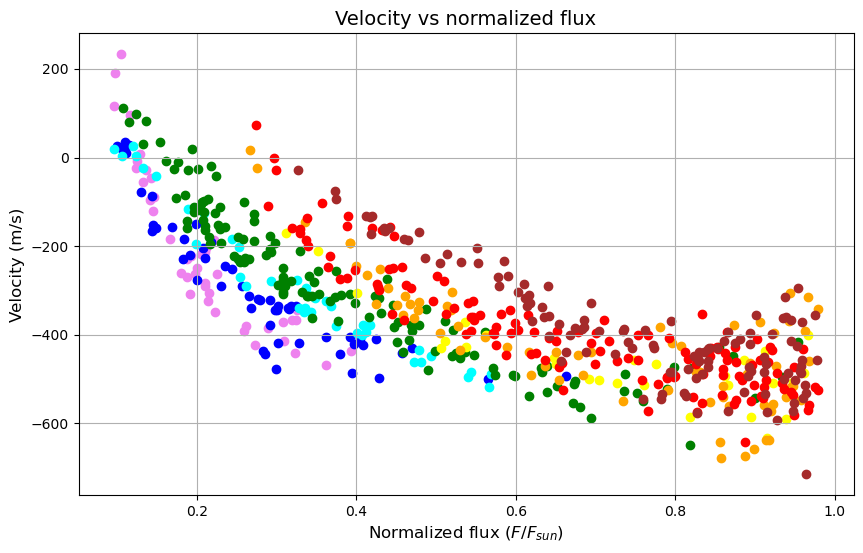

In [40]:
fig3, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(values_colors)):  
    ax.scatter(values_colors[i]['Flux'],values_colors[i]['Velocity'], c=colors[i])

ax.set_title('Velocity vs normalized flux',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{sun})$', fontsize=12)
ax.set_ylabel('Velocity (m/s)', fontsize=12)
ax.grid()

# fig3.savefig('Velocity.png')

### Second Derivate vs Normalized Flux

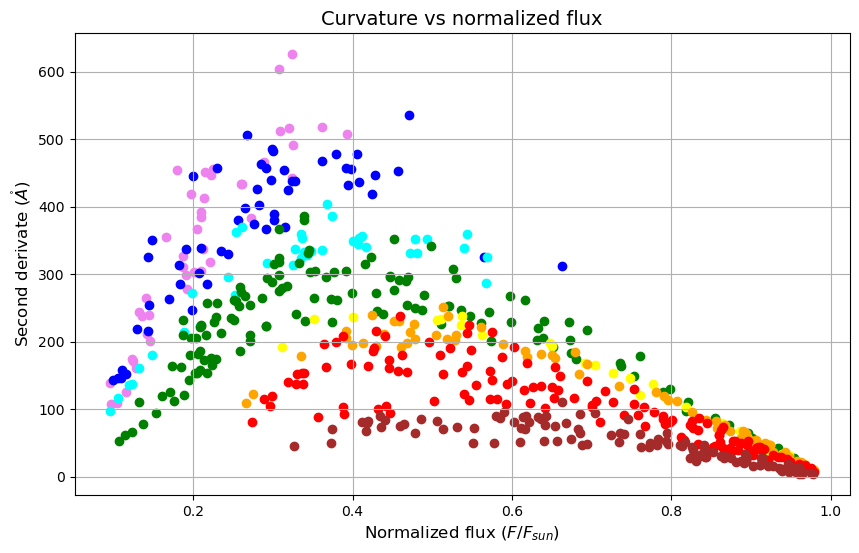

In [41]:
fig4, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(values_colors)):  
    ax.scatter(values_colors[i]['Flux'],values_colors[i]['2nd Derivate'], color=colors[i])

ax.set_title('Curvature vs normalized flux',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{sun})$',fontsize=12)
ax.set_ylabel(r'Second derivate $(\mathring{A})$',fontsize=12)
ax.grid()

# fig4.savefig('Curvature.png')

### Third Derivate Expresion vs Normalized Flux

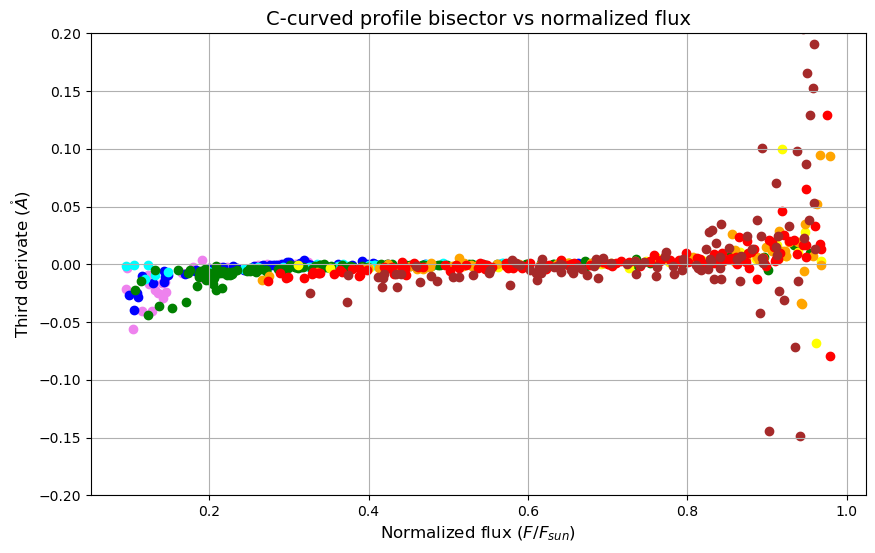

In [42]:
fig5, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(values_colors)):  
    ax.scatter(values_colors[i]['Flux'],values_colors[i]['3rd Derivate'], color=colors[i])

ax.set_title('C-curved profile bisector vs normalized flux',fontsize=14)
ax.set_xlabel(r'Normalized flux $(F/F_{sun})$',fontsize=12)
ax.set_ylabel(r'Third derivate $(\mathring{A})$',fontsize=12)
ax.set_ylim(-0.2,0.2)
ax.grid()

# fig5.savefig('CBisector.png')

### Convective Blueshift vs Line Depth

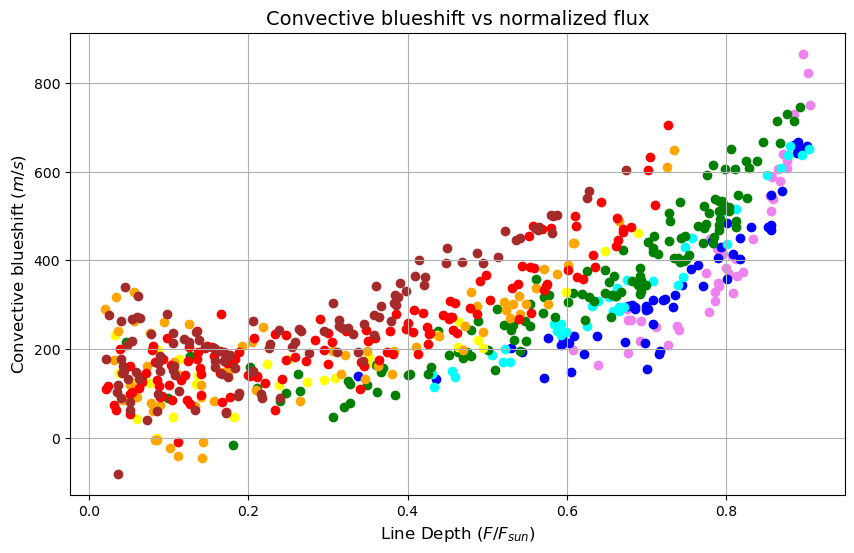

In [43]:
fig6, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(0,len(values_colors)):  
    ax.scatter(1-values_colors[i]['Flux'],values_colors[i]['Blueshift'], color=colors[i])

ax.set_title('Convective blueshift vs normalized flux',fontsize=14)
ax.set_xlabel(r'Line Depth $(F/F_{sun})$',fontsize=12)
ax.set_ylabel(r'Convective blueshift $(m/s)$',fontsize=12)
ax.grid()

# fig6.savefig('ConvectiveBlueshift.png')